# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys 
import glob
import ray
import logging 
import gc
import cv2
import time
import itertools
import pickle
import pathlib 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import xarray as xr
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.signal import medfilt
from pathlib import Path
from scipy.optimize import minimize_scalar
from scipy.stats import binned_statistic


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from kornia.geometry.transform import Affine
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# sys.path.append(str(Path('.').absolute()))
from NLMixedUtils.utils import *
import NLMixedUtils.io_dict_to_hdf5 as ioh5
from NLMixedUtils.format_data import *
from NLMixedUtils.models import *
from NLMixedScripts.fit_GLM import *
# pd.set_option('display.max_rows', None)

ray.init(
    ignore_reinit_error=True,
    logging_level=logging.ERROR,
)


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


{'node_ip_address': '184.171.84.86',
 'raylet_ip_address': '184.171.84.86',
 'redis_address': '184.171.84.86:45369',
 'object_store_address': '/tmp/ray/session_2022-02-15_15-49-31_293824_77819/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-02-15_15-49-31_293824_77819/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2022-02-15_15-49-31_293824_77819',
 'metrics_export_port': 55401,
 'node_id': 'e0136bc6725601ce98a955c64a8b109aae68770d04f3920dfae1f767'}

In [2]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['070921/J553RT' ]#,'101521/J559NC','102821/J570LT','110421/J569LT','122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani'] = dates_all[0]
args['train_shifter']=False
args['NoL1'] = False
args['Nepochs'] = 10000

params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

if args['NoL1'] == True: 
    L1 = 'NoL1'
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
else: 
    L1 = 'withL1'
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
ModelList = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))
model_info = params['date_ani2']+'_'+mod_name.replace('*', '')

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)


params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}'.format(params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter']))


Done Loading Unaligned data
Tot_units: (128,)
Model: 1, LinMix: False, move_features: None, Ncells: 108, train_shifter: False


# Load Paper Data

In [3]:
paper_fig_dir = (params['fig_dir'].parent.parent.parent / 'PaperFigs')
paper_fig_dir.mkdir(parents=True, exist_ok=True)
titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$']
move_clrs = ['blue','orange','green','red'] #["#ef476f","#ffd166","#06d6a0","#118ab2","#073b4c"]
q_clrs = ["#f72585","#7209b7","#3f37c9","#4cc9f0"] # Magenta to Blue
mod_clrs = ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"] #["#003d36", "#a38d00", "#ff3b05", "#70a0ff"]#["#136f63", "#e0ca3c", "#f34213", "#80a4ed"]
# mod_clrs = ["#136f63", "#e0ca3c", "#f34213", "#80a4ed"]
fontsize=10
mod_titles = ['pos','vis','add','mul','HF']

import matplotlib as mpl
mpl.rcParams.update({'font.size':         12,
                     'axes.linewidth':    2,
                     'xtick.major.size':  3,
                     'xtick.major.width': 2,
                     'ytick.major.size':  3,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.sans-serif':   "Arial",
                     'font.family':       "sans-serif",
                     'pdf.fonttype':      42,
                     'xtick.labelsize': 10,
                     'ytick.labelsize': 10,
                    })

In [4]:
# celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
# celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
# celltype = pickle.load(open(celltype_file,'rb'))

Kfold = 0
args['free_move']=True
mod_titles = ['pos','vis','add','mul','HF']
mod_clrs = ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"]
dates_all = ['070921/J553RT']# ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
ModelList_all,test_std,tuning_sig_all,tuning_sig_all2,NCells_all,bad_cells_all,test_nsp_all,hf_nsp_all,model_move_FM,model_move_HF = [],[], [], [], [], [], [], [], [], []
for d,date_ani in enumerate(dates_all):
    args['free_move'] = True
    args['date_ani'] = date_ani
    args['NoL1']=False
    args['do_shuffle']=False
    args['Nepochs'] = 10000
    params,_,_ = load_params(1,Kfold,args,debug=True)
    params['nt_glm_lag']=5
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    if args['NoL1'] == True: 
        L1 = 'NoL1'
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    else: 
        L1 = 'withL1'
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if ('VisNoShifter' not in path.stem) & ('SimRF' not in path.stem)]))
    ModelList_all.append(ModelList)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    model_move_FM.append(model_move)
    test_nsp_all.append(data['test_nsp'])
    test_std.append(np.var(data['test_nsp'],axis=0))
    tuning_sig_all.append(tuning_sig)
    tuning_sig_all2.append(tuning_sig2)
    NCells_all.append(len(tuning_sig2))
    args['free_move'] = False
    params,_,_ = load_params(0,Kfold,args,debug=True)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    hf_nsp_all.append(data['test_nsp'])
    model_move_HF.append(model_move)

ModelList_all = np.stack(ModelList_all)
test_std=np.hstack(test_std)
tuning_sig_all2 = np.hstack(tuning_sig_all2)
tuning_sig_all = np.vstack(tuning_sig_all)
model_move_FM = np.concatenate(model_move_FM,axis=0)
model_move_HF = np.concatenate(model_move_HF,axis=0)


Done Loading Unaligned data
Tot_units: (128,)
Done Loading Unaligned data
Tot_units: (128,)


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/NLMixedUtils/format_data.py:659: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


In [6]:

sf=4
params['nt_glm_lag']=5
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
All_data = {date_ani2[n]:{} for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    All_data[date_ani]['actual_meanfr'] = np.mean(test_nsp_all[da],axis=0)/params['model_dt']
    All_data[date_ani]['actual_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_nsp_all[da])[params['bin_length']:-params['bin_length']]
    All_data[date_ani]['actual_HF_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=hf_nsp_all[da])[params['bin_length']:-params['bin_length']]
    for ModelRun,fmod in enumerate(ModelList_all[da]):
        GLM_Data = ioh5.load(fmod)
        All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
        # All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = GLM_Data['r2_test'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_all'] = GLM_Data['vloss_trace_all'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_trace'] = np.nanmean(GLM_Data['vloss_trace_all'][:,-10:],axis=1)/np.nanvar(test_nsp_all[da],axis=0)
        if (ModelRun == 0):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['Cell_NN.0.weight'].copy()
        if (ModelRun == 1) | (ModelRun == 4):
            All_data[date_ani][mod_titles[ModelRun]+'_loss_regcv'] = GLM_Data['loss_regcv'].copy()
            RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
            RF_all_up = np.zeros((RF_all.shape[:2] + ( sf*(RF_all.shape[-2]), sf*(RF_all.shape[-1]))))
            for celln in range(RF_all.shape[0]):
                for t in range(RF_all.shape[1]):
                    RF_all_up[celln,t] = cv2.resize(RF_all[celln,t], (sf*(RF_all.shape[-1]), sf*(RF_all.shape[-2])))
            All_data[date_ani][mod_titles[ModelRun]+'_rf_up'] = RF_all_up
            All_data[date_ani][mod_titles[ModelRun]+'_rf_all'] = RF_all
        if (ModelRun == 2) | (ModelRun==3):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['posNN.Layer0.weight'].copy()
        if (ModelRun != 4):
            All_data[date_ani][mod_titles[ModelRun]+'_cc_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_smooth'][:,celln])[0, 1]) for celln in range(All_data[date_ani]['actual_smooth'].shape[1])])
            All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_smooth'][:,celln])[0, 1]**2) for celln in range(All_data[date_ani]['actual_smooth'].shape[1])])
        else: 
            All_data[date_ani][mod_titles[ModelRun]+'_cc_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_HF_smooth'][:,celln])[0, 1]) for celln in range(All_data[date_ani]['actual_HF_smooth'].shape[1])])
            All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = np.array([(np.corrcoef(All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'][:,celln],All_data[date_ani]['actual_HF_smooth'][:,celln])[0, 1]**2) for celln in range(All_data[date_ani]['actual_HF_smooth'].shape[1])])
        if (ModelRun == 4):
            All_data[date_ani]['HF_meanfr'] = np.mean(hf_nsp_all[da],axis=0)/params['model_dt']
            r2_FMHF_RF = np.zeros(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0])
            for celln in np.arange(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0]):
                r2_FMHF_RF[celln] = np.corrcoef(All_data[date_ani][mod_titles[1]+'_rf_all'][celln,2].flatten(),All_data[date_ani][mod_titles[-1]+'_rf_all'][celln,2].flatten())[0,1]
            All_data[date_ani][mod_titles[ModelRun]+'_FMHF_r2'] = r2_FMHF_RF

# celltypes_all = []
# for n,date_exp in enumerate([2,4,7,9]):
#     celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
#     celltype2 = celltype2.drop(bad_cells_all[n])
#     celltypes_all.append([celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])
# celltypes_all = np.hstack(celltypes_all)

da = 0
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Done Loading Unaligned data
Tot_units: (128,)


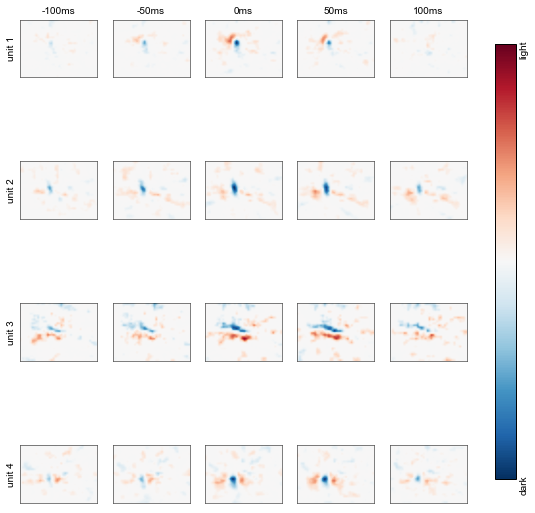

In [9]:
lag_ls = [-100,-50,0,50,100]
lag_list = [0,1,2,3,4]
cells = [22,34,42,101] #np.arange(18)
fig1, axs1 = plt.subplots(4,5,figsize=(10,10))
params['nt_glm_lag']=5
for n, cell in enumerate(cells):
    crange = np.max(np.abs(All_data[date_ani2[da]]['vis_rf_up'][cell]))
    for m,lag in enumerate(lag_list):
        ax = axs1[n,m]
        im = ax.imshow(All_data[date_ani2[da]]['vis_rf_up'][cell,lag],'RdBu_r',vmin=-crange,vmax=crange)
        axs1[0,m].set_title('{}ms'.format(lag_ls[m]),fontsize=fontsize)
    axs1[n,0].set_ylabel('unit {}'.format(n+1),fontsize=fontsize)

cbar2 = fig1.colorbar(im, ax=axs1,shrink=.8)
cbar2.set_ticks([-crange, crange])
cbar2.set_ticklabels(['dark', 'light'])
cbar2.ax.tick_params(labelsize=fontsize, rotation=90,width=0,length=0)
cbar2.outline.set_linewidth(1)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])